# 1. Load the data

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = yf.download("AAPL", start="2014-08-15", end="2024-08-15", multi_level_index=False)
data = data.reset_index()
data

C:\Users\lcy20\AppData\Local\Temp\ipykernel_32424\2708307960.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2014-08-15", end="2024-08-15", multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,2014-08-15,21.673101,21.719553,21.425358,21.655405,195804000
1,2014-08-18,21.934120,21.980572,21.673105,21.785915,190288000
2,2014-08-19,22.237152,22.270332,21.969501,21.989410,277596000
3,2014-08-20,22.246008,22.361031,22.108864,22.217253,210796000
4,2014-08-21,22.248222,22.327854,22.144258,22.246010,133912000
...,...,...,...,...,...,...
2511,2024-08-08,212.317062,213.202919,207.857921,212.117996,47161100
2512,2024-08-09,215.233429,215.770909,210.983301,211.112701,42201600
2513,2024-08-12,216.768036,218.741096,214.844804,215.313158,38028100
2514,2024-08-13,220.494934,221.112757,218.242841,218.242841,44155300


# 2.Data processing
making the data available for LSTM model

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Close   2516 non-null   float64       
 2   High    2516 non-null   float64       
 3   Low     2516 non-null   float64       
 4   Open    2516 non-null   float64       
 5   Volume  2516 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.1 KB


In [37]:
data.set_index("Date",inplace =True)

In [38]:
data.info()
data = data[["Close"]]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-08-15 to 2024-08-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Open    2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


# 3. Data normalization

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalar = StandardScaler() # change to StandardScalar to get another model
scalar_value = scalar.fit_transform(data.values.reshape(-1,1))
scalar_value

array([[-1.05923267],
       [-1.05494301],
       [-1.04996289],
       ...,
       [ 2.14701744],
       [ 2.20826643],
       [ 2.21563599]])

In [40]:
df_scalar = pd.DataFrame(scalar_value, index = data.index, columns=["Close"])
df_scalar

,Close
Date,
2014-08-15,-1.059233
2014-08-18,-1.054943
2014-08-19,-1.049963
2014-08-20,-1.049817
2014-08-21,-1.049781
...,...
2024-08-08,2.073869
2024-08-09,2.121797
2024-08-12,2.147017


# 4. Creating the sliding window sequence

In [41]:
import numpy as np
def create_sequence(data, look_back):
    x, y = [], []
    for i in range(look_back, len(data)):
        x.append(data.iloc[i - look_back:i].values)
        y.append(data.iloc[i].values)
    return np.array(x), np.array(y)



In [42]:
lb = 60
X, y = create_sequence(df_scalar, lb)
X.shape , y.shape

((2456, 60, 1), (2456, 1))

# 5. Train - test Split

In [43]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(X,y ,test_size=0.2 , random_state=42)
X_train.shape, x_test.shape

((1964, 60, 1), (492, 60, 1))

In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(LSTM(24, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))

model.add(Dense(Y_train.shape[1]))
model.compile(optimizer="adam", loss='mse', metrics = ['RootMeanSquaredError'])


c:\Users\lcy20\anaconda3\envs\git3.10\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# early stopping
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)

In [47]:
lstm_model = model.fit(X_train, Y_train, validation_split = 0.1, epochs = 100, batch_size=6, callbacks=[earlystop])
model.save("D:\GITHUBLSTM\LSTM_3_Layers.keras")

Epoch 1/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - RootMeanSquaredError: 0.1229 - loss: 0.0151 - val_RootMeanSquaredError: 0.0860 - val_loss: 0.0074
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - RootMeanSquaredError: 0.1105 - loss: 0.0123 - val_RootMeanSquaredError: 0.0817 - val_loss: 0.0067
Epoch 3/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - RootMeanSquaredError: 0.1100 - loss: 0.0121 - val_RootMeanSquaredError: 0.1277 - val_loss: 0.0163
Epoch 4/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - RootMeanSquaredError: 0.1130 - loss: 0.0128 - val_RootMeanSquaredError: 0.0617 - val_loss: 0.0038
Epoch 5/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - RootMeanSquaredError: 0.1075 - loss: 0.0116 - val_RootMeanSquaredError: 0.1068 - val_loss: 0.0114
Epoch 6/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - RootMeanSquaredError: 0.0954 - loss: 0.0091 - val_RootMeanSquaredError: 0.1211 - val_loss: 0.0147
Epoch 7/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - RootMeanSquaredErro

In [ ]:
prediction = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


# Forecasting


In [ ]:
prediction = scalar.inverse_transform(prediction)
y_test_rescal = scalar.inverse_transform(y_test)

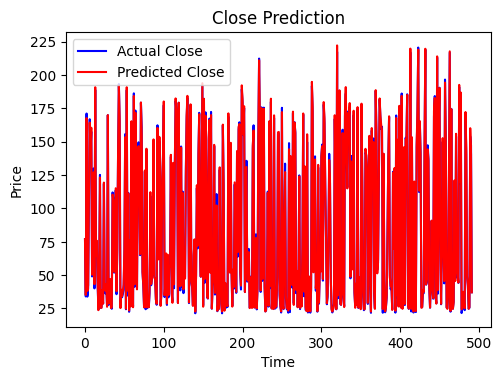

In [ ]:
plt.figure(figsize=(25,10))
for i, col in enumerate(df_scalar.columns):
    plt.subplot(2,3,i+1)
    plt.plot(y_test_rescal[:,i], color='b', label=f'Actual {col}')
    plt.plot(prediction[:,i], color='r', label=f'Predicted {col}')
    plt.title(f'{col} Prediction')
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
plt.tight_layout()

